### PUI2016_fhl204 Homework 6:
https://github.com/fedhere/PUI2016_fb55/blob/master/HW6_fb55/building_nrg_instructions.ipynb


In [302]:
from __future__ import print_function, division
import geopandas as gp
import pandas as pd
import os
import json
import urllib2
import pylab as pl
import statsmodels.api as sm

#s = json.load( open(os.getenv('PUI2016') +'/fbb_matplotlibrc.json') )
#pl.rcParams.update(s)

%pylab inline

Populating the interactive namespace from numpy and matplotlib


I am using geopanda. that is **not required** for this particular exercise, but geopand works with geospacial data: the shape files that we get from pluto for example.

PLEASE REMEMBER: seed your random functions if you need to use any, label your axes clearly, comment your code, use PEP8!


##We will use 2 different datasets.
##an interesting urban question is "can we measure and predict energy use based on observables that are easier to be acquired". for example the urban observatory at CUSP can monitor lights: they are a realtively easy observable. All you need is a camera, and a pipeline to process your data. But how does the light coming from a window relate to the total energy consumption? We generally postulate that light is a proxy for occupancy, and that occupancy is a good predictor of energy consumption.
##so let's test if the last link holds. If we have data on the energy consumed by a __building__ how well does that relate to the number of units in the building?

## data on energy consumption can be found here for the city of NY 
https://data.cityofnewyork.us/Environment/Energy-and-Water-Data-Disclosure-for-Local-Law-84-/rgfe-8y2z  

### IDEA:  
How well does the number of units in the building determine the energy consumed?

### Null Hypothesis:  
The measure of energy consumed in the building does not relate to the number of units in the building, statistical significance at p = 0.05.

### Alternate Hypothesis:  
The measure of energy consumed in the building increases proportionally to the number of units in the building, statistical significance at p = 0.05.


    

In [43]:
os.getenv('PUI2016')
os.getenv('PUIDATA')

'/home/cusp/fhl204/PUIdata'

In [ ]:
# OPTION 1: Load JSON
url = "https://data.cityofnewyork.us/api/views/rgfe-8y2z/rows.json?accessType=DOWNLOAD"

response = urllib2.urlopen(url)
data = response.read().decode("utf-8")
data = json.loads(data)
data

In [108]:
# OPTION 2: Load CSV
!curl -O 'https://data.cityofnewyork.us/api/views/rgfe-8y2z/rows.csv?accessType=DOWNLOAD'
#move to PUIDATA

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 3110k    0 3110k    0     0  1933k      0 --:--:--  0:00:01 --:--:-- 2213k


In [202]:
nrg = gp.GeoDataFrame.from_csv("~/PUIdata/Energy_and_Water_Data_Disclosure_for_Local_Law_84__2013_.csv")
nrg.columns

Index([u'NYC Borough, Block, and Lot (BBL)', u'Co-reported BBL Status',
       u'BBLs Co-reported',
       u'Reported NYC Building Identificaiton Numbers (BINs)',
       u'Street Number', u'Street Name', u'Borough', u'Zip Code',
       u'DOF Benchmarking Submission Status', u'Site EUI(kBtu/ft2)',
       u'Weather Normalized Site EUI(kBtu/ft2)', u'Source EUI(kBtu/ft2)',
       u'Weather Normalized Source EUI(kBtu/ft2)',
       u'Municipally Supplied Potable Water - Indoor Intensity (gal/ft²)',
       u'Automatic Water Benchmarking Eligible', u'Reported Water Method',
       u'ENERGY STAR Score', u'Total GHG Emissions(MtCO2e)',
       u'Direct GHG Emissions(MtCO2e)', u'Indirect GHG Emissions(MtCO2e)',
       u'Reported Property Floor Area (Building(s)) (ft²)',
       u'DOF Property Floor Area (Buildngs and Parking)(ft2)',
       u'Primary Property Type - Self Selected', u'DOF Number of Buildings'],
      dtype='object')

#however this datasets does not have the number of units. We can find that in the Pluto dataset.
reading in the Pluto data for manhattan, which will give me the number of units ber building   Manhattan/MNMapPLUTO.shp

In [33]:
!curl -O 'https://www1.nyc.gov/assets/planning/download/zip/data-maps/open-data/mn_mappluto_16v1.zip'
!unzip mn_mappluto_16v1.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 11.6M  100 11.6M    0     0  35.2M      0 --:--:-- --:--:-- --:--:-- 68.6M
Archive:  mn_mappluto_16v1.zip
  inflating: PLUTODD16v1.pdf         
  inflating: MN_Dcp_Mappinglot.dbf   
  inflating: MN_Dcp_Mappinglot.prj   
  inflating: MN_Dcp_Mappinglot.sbn   
  inflating: MN_Dcp_Mappinglot.sbx   
  inflating: MN_Dcp_Mappinglot.shp   
  inflating: MN_Dcp_Mappinglot.shp.xml  
  inflating: MN_Dcp_Mappinglot.shx   
  inflating: mn_pluto.dbf            
  inflating: mn_pluto.dbf.xml        
  inflating: MNMapPLUTO.BBL.atx      
  inflating: MNMapPLUTO.CD.atx       
  inflating: MNMapPLUTO.dbf          
  inflating: MNMapPLUTO.LandUse.atx  
  inflating: MNMapPLUTO.prj          
  inflating: MNMapPLUTO.sbn          
  inflating: MNMapPLUTO.sbx          
  inflating: MNMapPLUTO.shp          
  inflating: MNMapPLUTO.shp.xml      
  infla

In [89]:
#Pluto Shape File
floc = "~/PUIdata/MNMapPLUTO.shp"
bsize = gp.GeoDataFrame.from_file("MNMapPLUTO.shp")
bsize.columns

Index([    u'APPBBL',    u'APPDate',    u'Address', u'AllZoning1',
       u'AllZoning2', u'AreaSource', u'AssessLand',  u'AssessTot',
              u'BBL',   u'BldgArea',  u'BldgClass',  u'BldgDepth',
        u'BldgFront',      u'Block',   u'BoroCode',    u'Borough',
         u'BsmtCode',  u'BuiltCode',   u'BuiltFAR',     u'CB2010',
               u'CD',     u'CT2010',    u'ComArea',    u'CommFAR',
          u'CondoNo',    u'Council',  u'EDesigNum',  u'Easements',
       u'ExemptLand',  u'ExemptTot',        u'Ext',   u'FacilFAR',
       u'FactryArea',   u'FireComp', u'GarageArea', u'HealthArea',
         u'HistDist', u'IrrLotCode',    u'LandUse',   u'Landmark',
              u'Lot',    u'LotArea',   u'LotDepth',   u'LotFront',
          u'LotType',  u'LtdHeight', u'MAPPLUTO_F',   u'NumBldgs',
        u'NumFloors', u'OfficeArea',  u'OtherArea',   u'Overlay1',
         u'Overlay2',  u'OwnerName',  u'OwnerType', u'PLUTOMapID',
       u'PolicePrct',   u'ProxCode',    u'ResArea',   u'ResidF

In [90]:
bsize = bsize[['BBL','BldgArea','SanitBoro','SanitDist','SanitSub',\
            'UnitsRes','UnitsTotal','YearBuilt','ZipCode','geometry']]

In [203]:
# Create new dataframe with just the columns needed
nrg = nrg[['NYC Borough, Block, and Lot (BBL)',\
            'Site EUI(kBtu/ft2)',\
            'Reported Property Floor Area (Building(s)) (ft²)',\
            'DOF Property Floor Area (Buildngs and Parking)(ft2)',\
            'DOF Number of Buildings']]
nrg.columns

Index([u'NYC Borough, Block, and Lot (BBL)', u'Site EUI(kBtu/ft2)',
       u'Reported Property Floor Area (Building(s)) (ft²)',
       u'DOF Property Floor Area (Buildngs and Parking)(ft2)',
       u'DOF Number of Buildings'],
      dtype='object')

In [204]:
nrg.describe()

,"NYC Borough, Block, and Lot (BBL)",DOF Property Floor Area (Buildngs and Parking)(ft2),DOF Number of Buildings
count,1.601400e+04,1.446500e+04,14465.000000
mean,2.240854e+09,2.022015e+05,1.901348
std,1.234669e+09,5.360972e+05,5.826292
min,1.000010e+09,5.000800e+04,1.000000
25%,NaN,NaN,NaN
50%,NaN,NaN,NaN
75%,NaN,NaN,NaN
max,5.079910e+09,2.760000e+07,152.000000


In [205]:
BBL = nrg['NYC Borough, Block, and Lot (BBL)']
Site = nrg['Site EUI(kBtu/ft2)']
RepFA = nrg['Reported Property Floor Area (Building(s)) (ft²)']
DOFFA = nrg['DOF Property Floor Area (Buildngs and Parking)(ft2)']
nB = nrg['DOF Number of Buildings']
nrg.columns

Index([u'NYC Borough, Block, and Lot (BBL)', u'Site EUI(kBtu/ft2)',
       u'Reported Property Floor Area (Building(s)) (ft²)',
       u'DOF Property Floor Area (Buildngs and Parking)(ft2)',
       u'DOF Number of Buildings'],
      dtype='object')

In [206]:
#also tonumeric
#pd.to_numeric(RepFA)
# Returns True if what is passed as argument can be converted to a float, and False otherwise
def canconvert(mydata):
    try :
        float(mydata)
        return True
    except ValueError:
        return False

Now for every column i care about i can create an array, call it for eg. indx, of True and False (a Boolean array) that i can use as an index to pick entries that 
I want to use from my arrays of interest. I can replace the entries that failed to be converted to 'NaN'

(because my function return Trues when I can convert and False otherwise i actuallly want the complementary array: ~indx)

In [207]:
#create the indeces array here
#indx = ...
vfunc = np.vectorize(canconvert)
BBL_indx = vfunc(BBL) #, Zip, Site, RepFA, DOFFA, nB)
Site_indx = vfunc(Site) #, Zip, Site, RepFA, DOFFA, nB)
RepFA_indx = vfunc(RepFA) #, Zip, Site, RepFA, DOFFA, nB)

In [208]:
RepFA[~RepFA_indx] = float('NaN')
RepFA.astype(float)

Record Number
12086    918919.0
14354         NaN
12150     64200.0
12590         NaN
15591     50000.0
12135     61800.0
8523     102198.0
15920     46620.0
14241         NaN
15925     54029.0
9685          0.0
7540     171502.0
14360         NaN
10588     68750.0
14423         NaN
12515         NaN
3028     330000.0
14609         NaN
12096     69160.0
6666      52974.0
8914      82200.0
11586     63360.0
11714     52960.0
14307         NaN
12761         NaN
12091    154754.0
16027    465667.0
13378         NaN
14911     68329.0
15103     66546.0
           ...   
14559         NaN
14560         NaN
14748         NaN
14753         NaN
13582         NaN
13947         NaN
14777         NaN
14779         NaN
14409         NaN
13262         NaN
13261         NaN
12523         NaN
12529         NaN
12536         NaN
13929         NaN
13944         NaN
13945         NaN
13821         NaN
13829         NaN
13837         NaN
13838         NaN
13847         NaN
14352         NaN
12976         

In [209]:
Site[~Site_indx] = float('NaN')
Site.astype(float)

Record Number
12086      NaN
14354      NaN
12150      NaN
12590      NaN
15591      NaN
12135      NaN
8523       NaN
15920      NaN
14241      NaN
15925      NaN
9685       NaN
7540       NaN
14360      NaN
10588      NaN
14423      NaN
12515      NaN
3028     125.4
14609      NaN
12096      NaN
6666       NaN
8914       NaN
11586      NaN
11714      NaN
14307      NaN
12761      NaN
12091      NaN
16027      NaN
13378      NaN
14911      NaN
15103      NaN
         ...  
14559      NaN
14560      NaN
14748      NaN
14753      NaN
13582      NaN
13947      NaN
14777      NaN
14779      NaN
14409      NaN
13262      NaN
13261      NaN
12523      NaN
12529      NaN
12536      NaN
13929      NaN
13944      NaN
13945      NaN
13821      NaN
13829      NaN
13837      NaN
13838      NaN
13847      NaN
14352      NaN
12976      NaN
12978      NaN
12984      NaN
12987      NaN
12988      NaN
13472      NaN
13482      NaN
Name: Site EUI(kBtu/ft2), dtype: float64

In [210]:
BBL[~BBL_indx] = float('NaN')
BBL.astype(float)

Record Number
12086    1.000410e+09
14354    4.021460e+09
12150    2.027620e+09
12590    1.006700e+09
15591    2.048300e+09
12135    2.006120e+09
8523     3.050770e+09
15920    3.065710e+09
14241    4.004490e+09
15925    3.072240e+09
9685     3.087210e+09
7540     3.008640e+09
14360    4.022370e+09
10588    4.024310e+09
14423    4.031680e+09
12515    1.004370e+09
3028     1.013110e+09
14609    4.100970e+09
12096    1.006460e+09
6666     2.033970e+09
8914     3.058870e+09
11586    4.097150e+09
11714    4.103360e+09
14307    4.015250e+09
12761    1.009220e+09
12091    1.001242e+09
16027    4.042820e+09
13378    2.031170e+09
14911    1.007400e+09
15103    1.012770e+09
             ...     
14559    4.078700e+09
14560    4.078800e+09
14748    5.024508e+09
14753    5.024508e+09
13582    2.056428e+09
13947    3.046170e+09
14777    5.070408e+09
14779    5.070488e+09
14409    4.030880e+09
13262    2.025110e+09
13261    2.025070e+09
12523    1.004758e+09
12529    1.004860e+09
12536    1.005000e

In [211]:
##check that your conversion worked: e.g.
nrg['Site EUI(kBtu/ft2)'].astype(float)
#[...] check all columns you care about in both datasets. 
#Nan's are ok, but you must not get an error when you try the conversion
#the Pluto data is much better at not using spurious entries for numerical value columns. 
#but check you can use the columns you want
bsize.BBL.astype(float)
#notice i can use the attribute notation to refer to columns in bsize, 
#cause the column names do not have spaces!

0        1.015450e+09
1        1.007238e+09
2        1.016800e+09
3        1.013850e+09
4        1.011970e+09
5        1.002360e+09
6        1.008370e+09
7        1.001960e+09
8        1.022240e+09
9        1.011270e+09
10       1.011650e+09
11       1.021740e+09
12       1.009120e+09
13       1.007920e+09
14       1.012110e+09
15       1.011240e+09
16       1.009040e+09
17       1.010090e+09
18       1.020620e+09
19       1.020630e+09
20       1.008940e+09
21       1.005728e+09
22       1.004400e+09
23       1.019470e+09
24       1.008830e+09
25       1.020810e+09
26       1.021610e+09
27       1.008570e+09
28       1.008830e+09
29       1.020410e+09
             ...     
42667    1.014738e+09
42668    1.006208e+09
42669    1.007218e+09
42670    1.013428e+09
42671    1.019448e+09
42672    1.017298e+09
42673    1.018488e+09
42674    1.005008e+09
42675    1.020448e+09
42676    1.004518e+09
42677    1.020958e+09
42678    1.007688e+09
42679    1.008498e+09
42680    1.017298e+09
42681    1

#TO MERGE THE DATASET WE NEED A COMMON COLUMN
here is where you want to merge the datasets. You need a common column: the building id BBL
However the name of this variable (column) in the Energy dataset is     'NYC Borough, Block, and Lot (BBL)'. 

#### create a column 'BBL' 
in the nrg dataset to pass it to the 'on' keyword argument of the merge pandas method: 
#### pd.merge(..... on=['BBL']) 
will use the common column 'BBL' to join the information from the 2 datasets for each BBL value (check out the complete syntax!) 

In [233]:
nrg.rename(index = str, columns = {'NYC Borough, Block, and Lot (BBL)': 'BBL'}, inplace = True)
nrg.columns

Index([u'BBL', u'Site EUI(kBtu/ft2)',
       u'Reported Property Floor Area (Building(s)) (ft²)',
       u'DOF Property Floor Area (Buildngs and Parking)(ft2)',
       u'DOF Number of Buildings'],
      dtype='object')

In [213]:
#nrg1['BBL'] = nrg1['NYC Borough, Block, and Lot (BBL)']
bblnrgdata = pd.merge(nrg, bsize, how = 'inner', on = 'BBL')
bblnrgdata.head()

,BBL,Site EUI(kBtu/ft2),Reported Property Floor Area (Building(s)) (ft²),DOF Property Floor Area (Buildngs and Parking)(ft2),DOF Number of Buildings,BldgArea,SanitBoro,SanitDist,SanitSub,UnitsRes,UnitsTotal,YearBuilt,ZipCode,geometry
0,1.006700e+09,NaN,NaN,440360.0,1.0,440360,1,04,2B,0,1,1987,10001,"POLYGON ((982544.9469999969 212642.9668000042,..."
1,1.004370e+09,NaN,NaN,52390.0,1.0,52390,1,03,4B,0,4,1920,10009,"POLYGON ((988632.9397999942 204610.9329999983,..."
2,1.013110e+09,125.4,330000,313200.0,1.0,313200,1,06,3B,0,56,1977,10022,"POLYGON ((993141.1744000018 216172.3948000073,..."
3,1.009220e+09,NaN,NaN,98260.0,1.0,98260,1,06,1A,148,148,1963,10003,"POLYGON ((989369.5851999968 206338.7575999945,..."
4,1.007400e+09,NaN,68329,NaN,NaN,48800,1,04,1A,0,1,1920,10011,"POLYGON ((983418.6007999927 209632.8701999933,..."


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f32c39bf050>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7f32aa6e75d0>]], dtype=object)

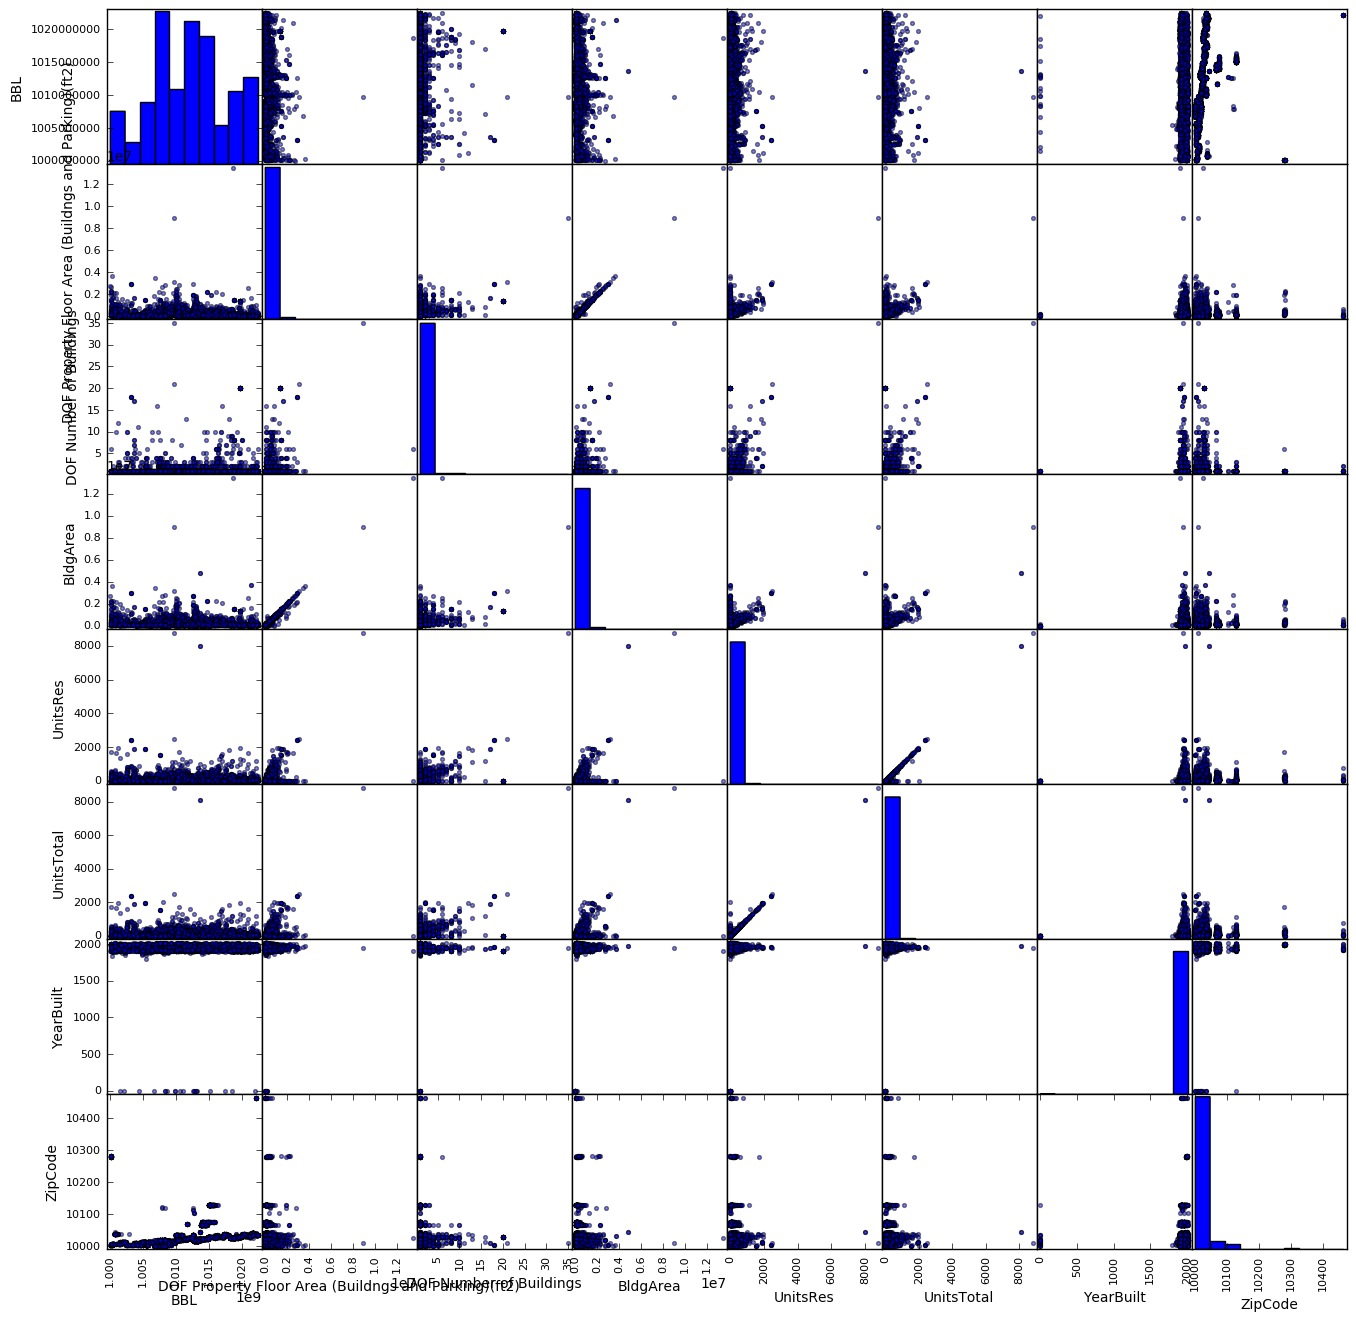

In [214]:
scatter_matrix(bblnrgdata, s = 30, figsize = (16,16))

In [215]:
bblnrgdata.describe()

,BBL,DOF Property Floor Area (Buildngs and Parking)(ft2),DOF Number of Buildings,BldgArea,UnitsRes,UnitsTotal,YearBuilt,ZipCode
count,6.492000e+03,5.974000e+03,5974.000000,6.492000e+03,6492.000000,6492.000000,6492.000000,6492.000000
mean,1.012037e+09,2.217178e+05,1.275527,2.139001e+05,96.906038,108.948090,1936.754159,10028.479821
std,5.665916e+06,3.685300e+05,1.697660,3.737116e+05,248.653949,252.170956,114.942467,37.193135
min,1.000010e+09,5.002800e+04,1.000000,0.000000e+00,0.000000,0.000000,0.000000,10001.000000
25%,1.008180e+09,NaN,NaN,6.569800e+04,0.000000,17.000000,1920.000000,10013.000000
50%,1.012344e+09,NaN,NaN,1.086070e+05,49.000000,58.000000,1930.000000,10022.000000
75%,1.015438e+09,NaN,NaN,2.120000e+05,106.250000,116.000000,1965.000000,10031.000000
max,1.022500e+09,1.343508e+07,35.000000,1.343508e+07,8759.000000,8805.000000,2015.000000,10463.000000


In [216]:
RPFA = bblnrgdata['Reported Property Floor Area (Building(s)) (ft²)'].astype(float)
SEUI = bblnrgdata['Site EUI(kBtu/ft2)'].astype(float)
SEUI.head()

0      NaN
1      NaN
2    125.4
3      NaN
4      NaN
Name: Site EUI(kBtu/ft2), dtype: float64

In [245]:
bblnrgdata['nrg'] =  RPFA * SEUI
bblnrgdata['nrg'].describe()

count    5.069000e+03
mean     2.136455e+08
std      5.245490e+09
min      0.000000e+00
25%               NaN
50%               NaN
75%               NaN
max      3.501452e+11
Name: nrg, dtype: float64

In [247]:
bblnrgdata.head()

,BBL,Site EUI(kBtu/ft2),Reported Property Floor Area (Building(s)) (ft²),DOF Property Floor Area (Buildngs and Parking)(ft2),DOF Number of Buildings,BldgArea,SanitBoro,SanitDist,SanitSub,UnitsRes,UnitsTotal,YearBuilt,ZipCode,geometry,nrg
0,1.006700e+09,NaN,NaN,440360.0,1.0,440360,1,04,2B,0,1,1987,10001,"POLYGON ((982544.9469999969 212642.9668000042,...",NaN
1,1.004370e+09,NaN,NaN,52390.0,1.0,52390,1,03,4B,0,4,1920,10009,"POLYGON ((988632.9397999942 204610.9329999983,...",NaN
2,1.013110e+09,125.4,330000,313200.0,1.0,313200,1,06,3B,0,56,1977,10022,"POLYGON ((993141.1744000018 216172.3948000073,...",41382000.0
3,1.009220e+09,NaN,NaN,98260.0,1.0,98260,1,06,1A,148,148,1963,10003,"POLYGON ((989369.5851999968 206338.7575999945,...",NaN
4,1.007400e+09,NaN,68329,NaN,NaN,48800,1,04,1A,0,1,1920,10011,"POLYGON ((983418.6007999927 209632.8701999933,...",NaN


once you have the dataframe with all the info you want, you want to 

#### plot Energy vs Number of Units in the Building. 
Remember: Energy TOTAL, not per sq ft...
Here you can choose what you think makes more sense for the number of units: all units, residential units...
#### make a 'natural' scale scatter plot first 
it will look really bad cause all the datapoints are at very low Unit numbers while the Unit number range actually goes up to 8000.
#### perhaps zoom into the region 
where most points are by cutting your x and y axis plotted: e,g, use xlim=(1000,1e10), ylim=(1,1000), where the numbers to be plugged in depend on exactly what you chose to plot

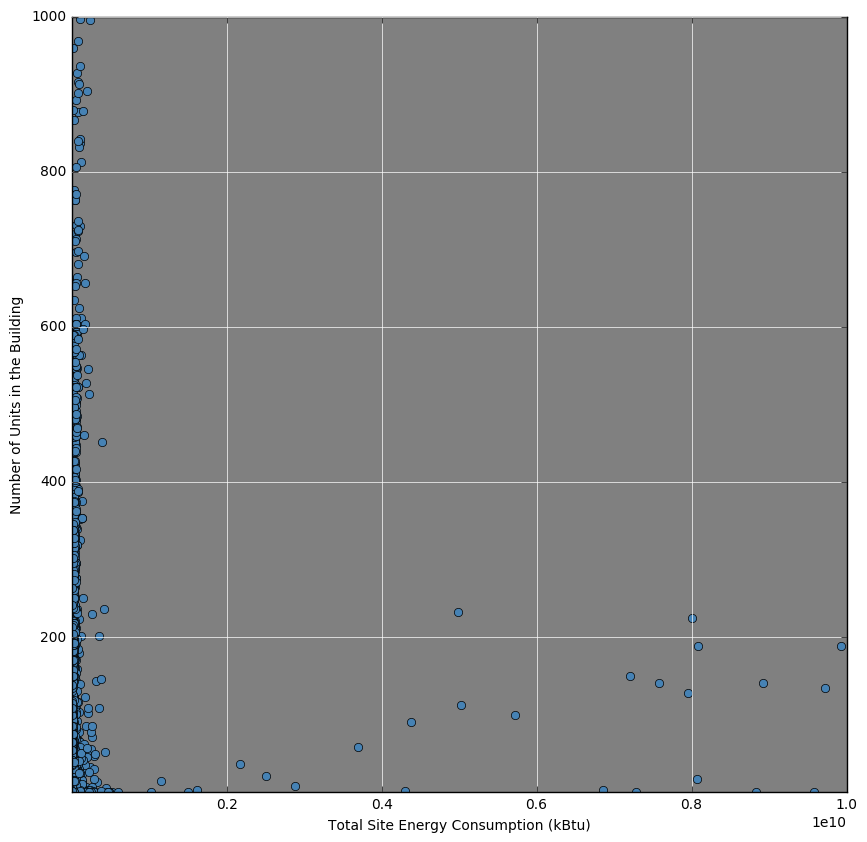

In [271]:
y = bblnrgdata['UnitsTotal']
x = bblnrgdata['nrg']

fig = pl.figure(7,figsize=(10,10))
#fig.patch.set_facecolor('black')

ax = fig.add_subplot(111, axisbg='gray')
#ax.tick_params(color='gray', labelcolor='gray')
#for spine in ax.spines.values():
#        spine.set_edgecolor('gray')
ax.xaxis.grid(True, which="major", linestyle='-', color='white') 
ax.yaxis.grid(True, which="major", linestyle='-', color='white')
plt.axis([1000, 1e10, 1, 1000])

ax.set_ylabel("Number of Units in the Building", fontsize=10)
ax.set_xlabel("Total Site Energy Consumption (kBtu)", fontsize=10)

ax.plot(x, y, 'o', color='SteelBlue') #log plot , loglog=True

In [255]:
#Remove Outliers
bblnrgdata_cut = bblnrgdata[bblnrgdata.nrg > 1000] 
bblnrgdata_cut

,BBL,Site EUI(kBtu/ft2),Reported Property Floor Area (Building(s)) (ft²),DOF Property Floor Area (Buildngs and Parking)(ft2),DOF Number of Buildings,BldgArea,SanitBoro,SanitDist,SanitSub,UnitsRes,UnitsTotal,YearBuilt,ZipCode,geometry,nrg
2,1.013110e+09,125.4,330000,313200.0,1.0,313200,1,06,3B,0,56,1977,10022,"POLYGON ((993141.1744000018 216172.3948000073,...",4.138200e+07
10,1.010140e+09,154.9,841709,NaN,NaN,855000,1,05,None,0,2,1999,10036,"POLYGON ((987726.6307999939 214846.9886000007,...",1.303807e+08
15,1.007660e+09,122.3,59468,53168.0,1.0,53168,1,04,1A,0,8,1912,10011,"POLYGON ((984350.5375999957 209226.3930000067,...",7.272936e+06
16,1.008150e+09,117,364000,364000.0,1.0,364000,1,05,1H,0,24,1954,10018,"POLYGON ((988118.5699999928 213939.7745999992,...",4.258800e+07
18,1.005050e+09,82.1,235370,214110.0,1.0,214110,1,02,1B,0,24,1926,10013,"POLYGON ((982849.6037999988 203886.2427999973,...",1.932388e+07
19,1.021420e+09,137.69999999999999,64806,64816.0,1.0,64816,1,12,2B,54,62,1924,10032,"POLYGON ((1001098.760600001 246912.0266000032,...",8.923786e+06
20,1.021750e+09,103.2,62839,62847.0,1.0,62847,1,12,3B,75,85,1920,10040,"POLYGON ((1004289.818200007 253753.9873999953,...",6.484985e+06
21,1.003360e+09,74,98000,98052.0,1.0,98052,1,03,2B,128,128,1982,10002,"POLYGON ((988978.3273999989 200091.3111999929,...",7.252000e+06
22,1.008070e+09,130,204417,221227.0,1.0,221227,1,05,1H,0,10,1912,10001,"POLYGON ((987142.364199996 212082.1648000032, ...",2.657421e+07
23,1.008580e+09,138.30000000000001,60110,60110.0,1.0,60110,1,05,1B,56,61,1923,10016,"POLYGON ((988236.0600000024 210446.8111999929,...",8.313213e+06


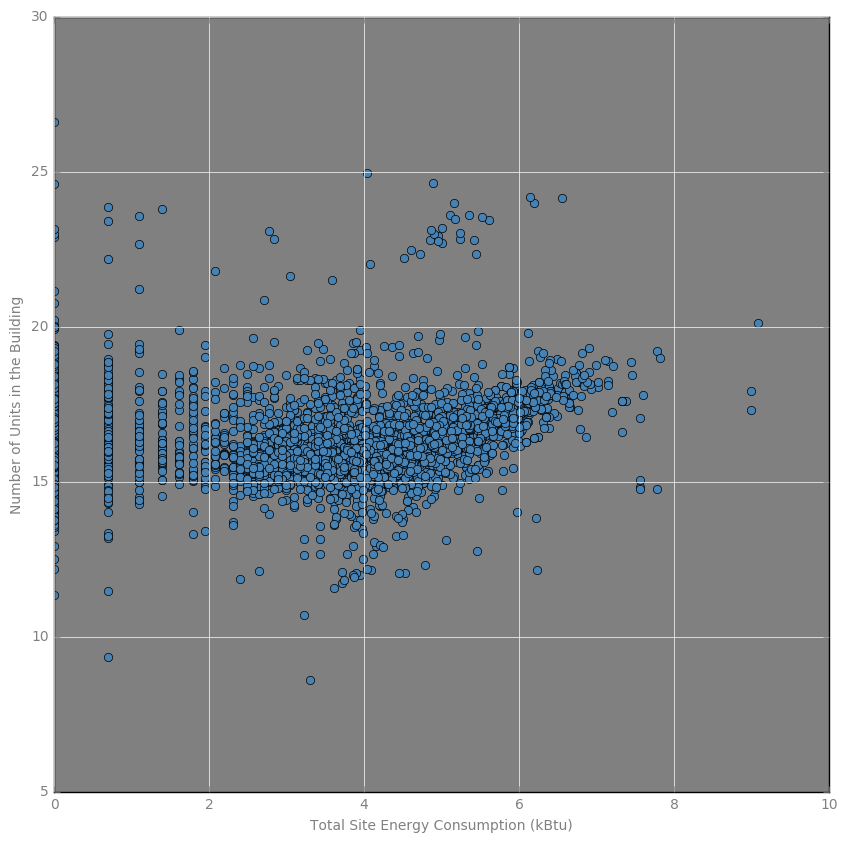

In [287]:
y = bblnrgdata_cut['UnitsTotal']
x = bblnrgdata_cut['nrg']

fig = pl.figure(7,figsize=(10,10))
#fig.patch.set_facecolor('black')

ax = fig.add_subplot(111, axisbg='gray')
ax.tick_params(color='gray', labelcolor='gray')
#for spine in ax.spines.values():
#        spine.set_edgecolor('gray')
ax.xaxis.grid(True, which="major", linestyle='-', color='white') 
ax.yaxis.grid(True, which="major", linestyle='-', color='white')
#plt.axis([10, 1e3, 1000, 10000])

ax.set_ylabel("Number of Units in the Building",color='gray', fontsize=10)
ax.set_xlabel("Total Site Energy Consumption (kBtu)",color='gray', fontsize=10)

ax.plot(log(y), log(x), 'o', color='SteelBlue') #log plot , loglog=True

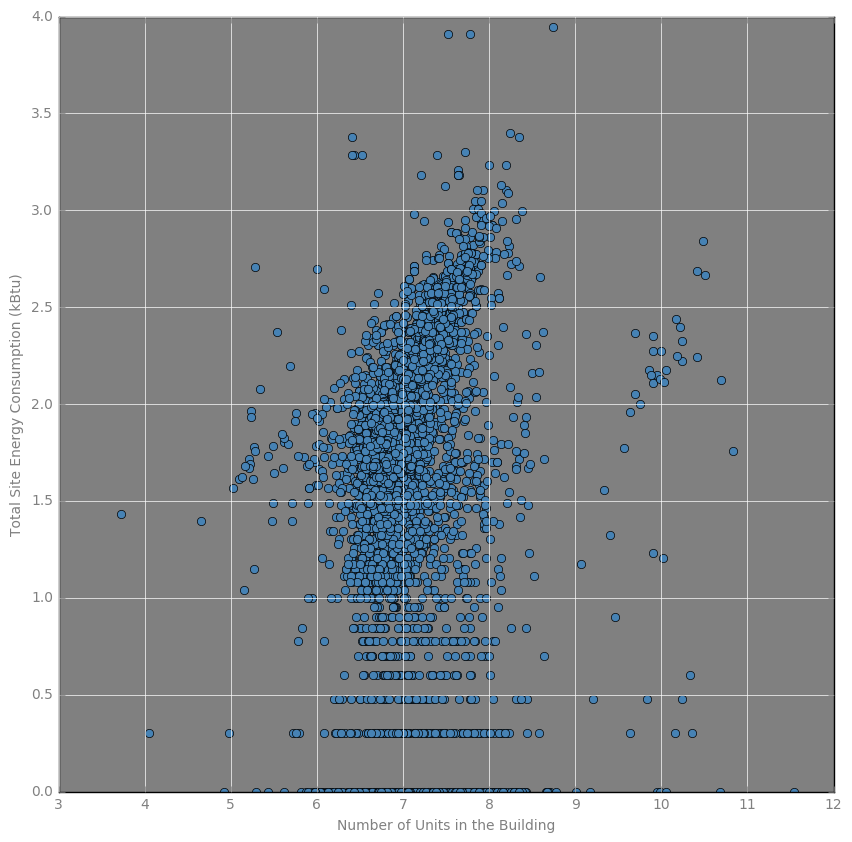

In [281]:
y = bblnrgdata_cut['UnitsTotal']
x = bblnrgdata_cut['nrg']

fig = pl.figure(7,figsize=(10,10))
#fig.patch.set_facecolor('black')

ax = fig.add_subplot(111, axisbg='gray')
ax.tick_params(color='gray', labelcolor='gray')
#for spine in ax.spines.values():
#        spine.set_edgecolor('gray')
ax.xaxis.grid(True, which="major", linestyle='-', color='white') 
ax.yaxis.grid(True, which="major", linestyle='-', color='white')
#plt.axis([100, 1e10, 1000, 1000])

ax.set_xlabel("Number of Units in the Building",color='gray', fontsize=10)
ax.set_ylabel("Total Site Energy Consumption (kBtu)",color='gray', fontsize=10)

ax.plot(log10(x), log10(y), 'o', color='SteelBlue') #log plot , loglog=True

IndexError: indices are out-of-bounds

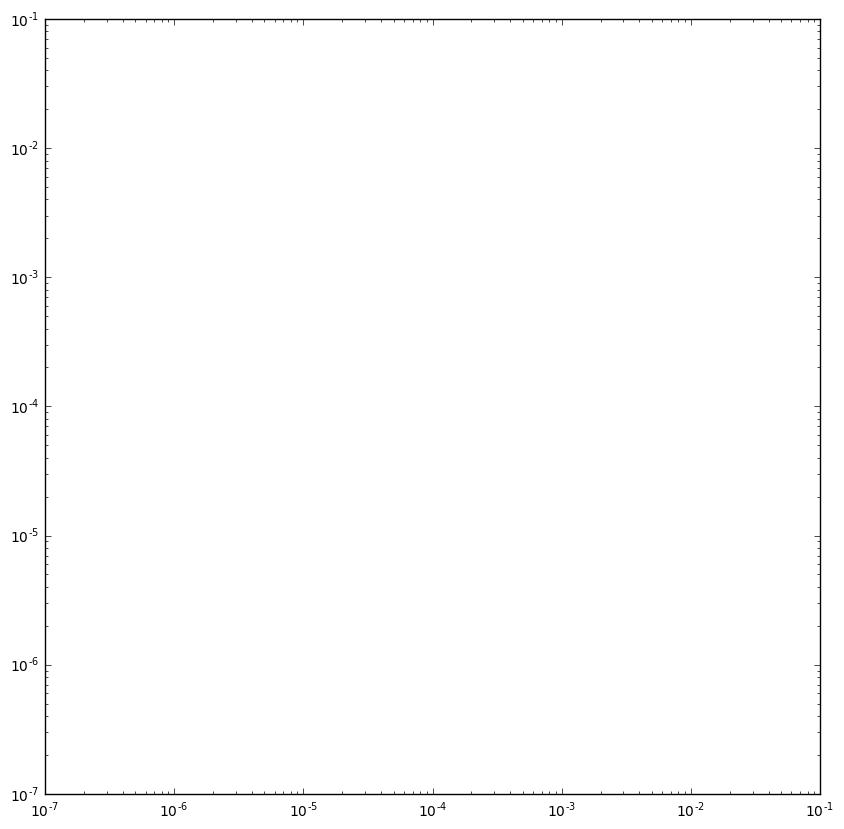

In [301]:
pl.figure(figsize(10,10))

y = bblnrgdata_cut['UnitsTotal']
x = bblnrgdata_cut['nrg']

p = bblnrgdata_cut.plot(kind = 'scatter', y = bblnrgdata_cut['nrg'], \
                        x = bblnrgdata_cut['UnitsTotal'], marker = 'o', loglog = True)

when the points in a plot all look scrunched against the axis try a log plot! in pandas you enable that with the keyword 'loglog' :
bblnrgdata.plot(..... loglog=True)

NOTICE THAT YOU WILL STILL HAVE TO CUT YOUR DATASET! in my data i had a lot of energy datapoints that were exactly 0. I removed these "outliers" which I think are truly outliers in the sense that they are misreported numbers. you can remove the data that have nrg==0 (or nrg < some sensible threshold choice) by indexing your array:
something like bblnrgdata_cut = bblnrgdata[bblnrgdata.nrg>1000]

also i removed the buildings with several thousand units. points like that at the edge of my range would have a lot of "LEVERAGE", however  they are not suprious entries like the 0, which i believe are missing values, or perhaps abandoned lots. these are good datapoint that i need to throw away functionally for my analysis to work, but that should be stated clearly.


Now fit a line through the data. you can use whatever you want to do it: 
statsmodels, scipy, any other package, or write your own minimization of the residuals
## BUT REMEMBER: we see hints of a lienar relation in log space! so we want to fit a line to the log of our variables, not the variables themselves:

if you used statsmodels it would look something like this:

In [307]:
X = sm.add_constant(np.log10(x))
model = sm.OLS(np.log10(y), X, missing='drop').fit() # ignores entires where x or y is NaN
#fit = model.fit()
#return fit.params[1], fit.params[0], fit # could also return stderr in each via fit.bse

In [ ]:
#X = sm.add_constant(np.log10(x))
#print X
#model = sm.OLS(np.log10(y), X, missing='drop').fit() # ignores entires where x or y is NaN
#fit = model.fit()
#return fit.params[1], fit.params[0], fit # could also return stderr in each via fit.bse

In [308]:
# OLS Analytical Regression Fit Line
from scipy import stats

y = bblnrgdata_cut['UnitsTotal']
x = bblnrgdata_cut['nrg']

ols_y = np.array([0., bblnrgdata_cut['UnitsTotal']])

ols_x = np.array([0., bblnrgdata_cut['nrg']])

#ols_y = np.array([0.] + [allfemales[k]['Median income'][1] \
#                             for k in ['all', 'white', 'black',
#                                     'hispanic','asian']])

cor = stats.spearmanr(ols_x, ols_y)
beta1 = cor[0] * ols_y.std() / ols_x.std()
beta0 = ols_y.mean() - beta1 * ols_x.mean()
beta0, beta1

ValueError: setting an array element with a sequence.

remember to choose wisely which is your DEPENDENT and which is your INDEPENDENT variable. 
both for what you want to do logically (what changes as a functino of what) but also based on which  variable has a 'sensible' distribution that allows you to fit a function to it: 
    you need your independent variable to span a large range, and to be spread somewhat evenly in the range, 
    rather than just clustered in a spot
    


In [ ]:
# fits and plots here
# your plots should show datapoints (as scatter plot) and models (as lines)

In [ ]:
x = all_males
y = all_females
x1 = np.arange(0.,50000.,10000) 

mrnew = myregression(x, y)
xnew = np.linspace(0.,100000.,10000)

fig = pl.figure(figsize=(20,10))

ax2 = fig.add_subplot(222)
ax2.scatter(x, y, label = "Median Incomes")
ax2.set_ylabel('Female Median Income')
ax2.set_xlabel('Male Median Income')

ax2.plot(x1, x1, lw=2, color = 'IndianRed', label = "Income Equity")
ax2.plot(xnew, mrnew.predict(xnew), 'r', alpha=0.5, label = "My Regression Fit through 0")
ax2.plot(xnew, model_income.predict(sm.add_constant(xnew)), 'g', alpha=0.5, label = "My Regression Fit")
ax2.plot(xnew, beta0 + beta1 * (xnew), 'b', alpha=0.5, label = "OLS Analytical Regression")

ax2.axis([0, 50000, 0, 50000])
ax2.legend(loc = 'upper right', fontsize = 'small')

try making a fit for energy vs units AND a fit for units vs energy. 
tell me which is better. 

##look at the fit summary: which is better? could you do a likelihood ratio test here? why or why not??

In [ ]:
#answer the question here

# my OLS summary. 
# Yours may be somewhat different depending on how you cut the data

##now fit a second degree curve to it: a*x^2+b*x+c. 
that is still called a linear fir by the way, the "linear" definition refers to the PARAMETERS being linear, not to the variable!
you can use np.polyfit for example (an example showned in the other assignment notebook), with order 2 instead of 1,

np.polyfit(x, y, 2)

or statmodels.formula.api passing a formula like 

formula = 'y ~ 1 + x + I(x ^ 2.0)'

##look at the fit summary: which is better? could you do a likelihood ratio test here? why or why not??

In [ ]:
print ("LR : ", -2 * (-linemodel.llf - (-curvemodel.llf)))
print ("LR from statsmodels:", curvemodel.compare_lr_test(linemodel))

EXTRA CREDIT: 
    
use WLS the weighted sq fit instead of OLS. you need to give weights to your points: 
estimates of the errors. the easiest thing is the sqrt of the datapoint value.
if you want to be more sophisticated you can estimate the variance of your data
near each point and use that 

Lastly: do it by hand and create a function that minimizes the residuals: 
       
the residuals are the sum of the differences between data and model: 
in the case of a line fit model (and you can use your errors if you did the extra credit!)

sum(np.log(bblnrgdatacut.nrg) - np.log(bblnrgdatacut.UnitsTotal)*a+b )^2

where a and b are the parameters returned by the line fitter. 
for each data point you can calculate the model at different values : for example in a range B = np.arange (-100, 100, 1) for the intercept, and A = np.arange(-50.0, 50.0, 0.5) for the slope

write it as a nested for loop (or challenge yourself and vectorize it!) with a loop inside another ranging all poissible combinations of the 2 variables (i use enumerate to get both an index from 0 to the size of my array, which i assign to i (and j) and the value of the array at that index - look up the syntax!):


for i,a in enumerate(A):

    for j,b in enumerate(B):
    
         Lsurface[i][j].....

this gives you a 2D array that represents your likelihood surface! what we do to find a good fit is find the minimum (lowest point) on this surface. 

you can plot a surface (a 2D array) with pl.imshow(Lsurface) as a "heatmap"

but when you do that you will find that the plot is very uninformative. just like you did before with the data, plot the log of it (pl.imshow(np.log(Lsurface))
and see if it helps!
also make sure your x and y axes tick numbers represent the range of values, not the cell index, which is the default for imshow. do that with the keyword extent: 
pl.imshow(Lsurface, .... , extent = [minimum, and max of your y array, minimum, and max of your x array]...) (notice that the numbers are switched! make sure to verify which axis is the slope, which is the intercept)

In [ ]:
##create the array
##[...]
##pl.figure(figsize=(10,10))
##pl.title ("log likelihood surface", fontsize = 22)
##pl.imshow(np.log(Lsurface), extent = ..., aspect=...)
##[...]
##pl.colorbar()

EXTRA CREDIT: get creative with the dataset! can you make an insigntful plot to show any structure in the data?
    
below is my silly attempt at that




In [ ]:
bblnrgdatacut['YearBuilt'][bblnrgdatacut['YearBuilt']<1800]=1800

bblnrgdatacut.plot(kind='scatter',x='nrg',y='UnitsTotal', fontsize=22, colormap='gist_rainbow', alpha = 1, marker='o',  figsize=(16, 14), loglog=True,  xlim=(1000,1e11), ylim=(1,1000), c=bblnrgdatacut['YearBuilt']-1900, s=bblnrgdatacut['UnitsTotal']/bblnrgdatacut['UnitsRes']*100)